## Importing packages

In [1]:
import pandas as pd
import numpy as np
from IPython import display

import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')

from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px
sns.set(style="darkgrid")

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Downloading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# df=pd.read_csv("https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv")
path="drive/MyDrive/Colab Notebooks/sentiment_analysis/Data/twitter_data_analysis2022-03-05-18.csv" 
df=pd.read_csv(path, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11'], header= None) #, on_bad_lines='skip'

## Data Pre-processing

In [27]:
# Manipulation the dataframe, which columns to keep, colum renaming etc.
def prelim_processing(df):
  df=df[['col6', 'col7', 'col3']]
  df.columns= ['user_name', 'date', 'text']
  df.user_name=df.user_name.astype('category') #converts this column to categorical types
  df.user_name=df.user_name.cat.codes
  # df.set_index('user_name', inplace=True)
  df.date= pd.to_datetime(df.date).dt.date
  return df

#Pre-processing tweets
def fine_processing(df, more_words):
  stop_words=set(stopwords.words('english'))
  stop_words.update(more_words)

  remove_words = lambda x: ' '.join([word for word in x.split() if word not in stop_words])
  remove_url = lambda x: re.sub(r'https\S+', '',str(x)) # which starts with https and there is no whitespace in it
  remove_mentions = lambda x: re.sub(r'@\S+', '',str(x))
  to_lower = lambda x: x.lower()
  puncs = string.punctuation
  mod_puncs =puncs[0:2]+puncs[3:]
  remove_puncs = lambda x: x.translate(str.maketrans('','',mod_puncs))
  
  texts = df['text']
  mod_texts = texts.apply(remove_url)
  mod_texts = mod_texts.apply(remove_mentions)
  mod_texts = mod_texts.apply(to_lower) 
  mod_texts = mod_texts.apply(remove_puncs)
  mod_texts =mod_texts.apply(remove_words)
  return mod_texts

df=prelim_processing(df)
more_words=['covid','#coronavirus','#coronavirusoutbreak','#coronavirusPandemic','#covid19','#covid_19','epitwitter','#ihavecorona','amp','coronavirus','covid19', 'rt']
mod_texts=fine_processing(df, more_words)





/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
#Put the cleaned text in main dataframe
df.text=mod_texts
df.head()

0    rt  seventeen scoups dokyeom and seungkwan tes...
1    rt  released during the driest exam season and...
2    rt   1 patients with long covid also called po...
3    nah haven’t felt this shitty in a long time fu...
4    bbc news  covid in scotland unvaccinated women...
Name: text, dtype: object

# Visualizing most common words

In [68]:
#create a big list of words out of all the tweets
words_list=[word for line in mod_texts for word in line.split()]
word_counts=Counter(words_list).most_common(30)
# word_counts
words_df=pd.DataFrame(word_counts)
words_df.columns=['word','frq']
px.bar(words_df, x='word', y='frq', title ='Most common words')

In [45]:
a=df[df['text'].str.contains('ukraine')]


## VADER (SENTIMENT ANALYSIS)

In [67]:
sid=SentimentIntensityAnalyzer()
ps= lambda x: sid.polarity_scores(x)
sentiment_scores=df.text.apply(ps)
sentiment_df=pd.DataFrame(data=list(sentiment_scores))

In [34]:
labelize=lambda x: 'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['label']=sentiment_df.compound.apply(labelize)


In [35]:
#join 2 dataframes
data=df.join(sentiment_df.label)
data.head()

,user_name,date,text,label
0,2877,2022-03-05,seventeen scoups dokyeom seungkwan tested posi...,positive
1,3357,2022-03-05,released driest exam season severe wave still ...,positive
2,1847,2022-03-05,1 patients long also called postacute sequelae...,neutral
3,4086,2022-03-05,nah haven’t felt shitty long time fuck,negative
4,482,2022-03-05,bbc news scotland unvaccinated women resume iv...,neutral


In [37]:
counts_df=data.label.value_counts().reset_index()
counts_df

,index,label
0,positive,2558
1,negative,2309
2,neutral,2150


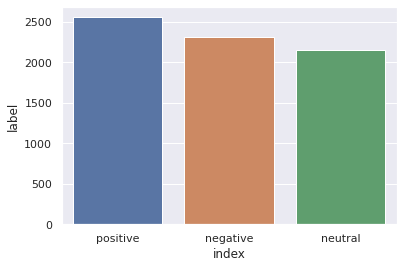

In [38]:
sns.barplot(x='index',y='label', data=counts_df)

In [39]:
# data_agg=data[['user_name','date','label']].groupby(['date','label']).count().reset_index()
# data_agg.columns=['date','label','counts']

In [69]:
# px.line(data_agg,x='date',y='counts',color='label', title="daily tweets sentiment analysis")

## Plot the word cloud

In [74]:
data.head()

,user_name,date,text,label
0,2877,2022-03-05,seventeen scoups dokyeom seungkwan tested posi...,positive
1,3357,2022-03-05,released driest exam season severe wave still ...,positive
2,1847,2022-03-05,1 patients long also called postacute sequelae...,neutral
3,4086,2022-03-05,nah haven’t felt shitty long time fuck,negative
4,482,2022-03-05,bbc news scotland unvaccinated women resume iv...,neutral


In [76]:
positive = data[data['label']=='positive']
negative = data[data['label']=='negative']
neutral = data[data['label']=='neutral']


In [85]:
# sentences = data['text'].tolist()
sentences = neutral['text'].tolist()
sentences_as_one_string =" ".join(sentences)

In [86]:
from wordcloud import WordCloud

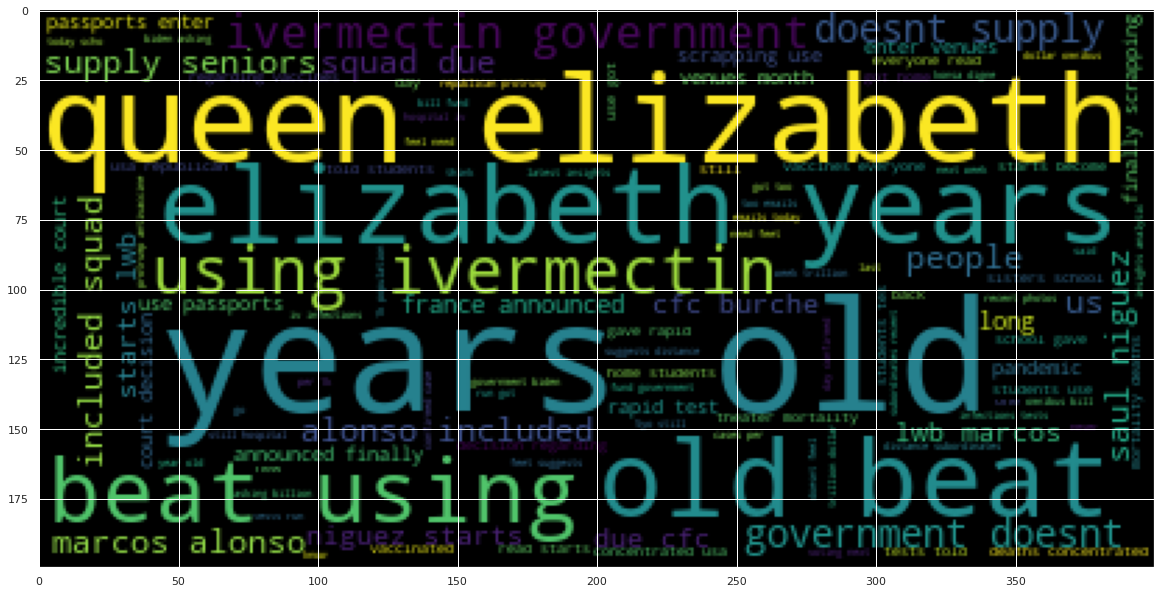

In [87]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))